# Project: 영-프 번역기 만들기 (단어 레벨)
- seq2seq
- machine translation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

import re

In [2]:
file_path = "./data/fra.txt"
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')

# 상위 33000개 샘플만 가져오기
lines = lines[["eng", "fra"]][:33000]
len(lines)

33000

In [3]:
lines.head(10)

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
5,Hi.,Salut.
6,Run!,Cours !
7,Run!,Courez !
8,Run!,Prenez vos jambes à vos cous !
9,Run!,File !


## 1. Preprocessing

### 텍스트 전처리
- 소문자로 변경
- 구두점 분리
- 디코더 문장의 경우 `<start>`,  `<end>` 토큰 추가

In [4]:
def preprocessing(line, is_decode=False, sos_token="<sos> ", eos_token=" <eos>"):
    # 소문자로 변환
    line = line.lower()
    # 구두점 분리
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r"[^a-zA-Z\u00C0-\u017F!.?]+", r" ", line) # 프랑스어 악센트 포함된 알파벳도 포함하도록 한다.
    line = re.sub(r"\s+", r" ", line)
    line = line.strip() # 앞뒤 공백 제거
    
    if is_decode:
        line = sos_token + line + eos_token
    
    return line

In [5]:
# 확인
print(preprocessing("This @_is ;;;sample        sentence.")) # 필터링 잘되는지 확인
print(preprocessing("This @_is ;;;sample        sentence.", is_decode=True))

this is sample sentence .
<sos> this is sample sentence . <eos>


In [6]:
lines.eng= lines.eng.apply(lambda x: preprocessing(x))
lines.fra = lines.fra.apply(lambda x: preprocessing(x, is_decode=True))
lines.head(10)

,eng,fra
0,go .,<sos> va ! <eos>
1,go .,<sos> marche . <eos>
2,go .,<sos> en route ! <eos>
3,go .,<sos> bouge ! <eos>
4,hi .,<sos> salut ! <eos>
5,hi .,<sos> salut . <eos>
6,run !,<sos> cours ! <eos>
7,run !,<sos> courez ! <eos>
8,run !,<sos> prenez vos jambes à vos cous ! <eos>
9,run !,<sos> file ! <eos>


## 2. Tokenize

### 띄어쓰기 단위로 토큰화 수행

In [7]:
def tokenize(lines):
    tokenizer = Tokenizer(num_words=7000,
                          filters=" ", 
                          lower=False)
    tokenizer.fit_on_texts(lines)
    
    tensor = tokenizer.texts_to_sequences(lines)
    
    return tensor, tokenizer

In [8]:
eng_tensor, eng_tokenizer = tokenize(lines.eng)
fra_tensor, fra_tokenizer = tokenize(lines.fra)

In [9]:
# 확인
fra_tensor[:5]

[[1, 69, 9, 2],
 [1, 314, 3, 2],
 [1, 24, 495, 9, 2],
 [1, 643, 9, 2],
 [1, 644, 9, 2]]

### input, target 설정

In [10]:
# 프랑스어 시퀀스는 정답 데이터, 디코더 입력용 두 가지 버전으로 준비
encoder_input = eng_tensor
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index["<eos>"] ] for line in fra_tensor] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index["<sos>"] ] for line in fra_tensor]

In [11]:
# 확인
print(decoder_input[:3]) # "2"가 사라졌는지 확인
print(decoder_target[:3]) # "1"이 사라졌는지 확인

[[1, 69, 9], [1, 314, 3], [1, 24, 495, 9]]
[[69, 9, 2], [314, 3, 2], [24, 495, 9, 2]]


### padding 추가

In [12]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1

max_eng_seq_len = max([len(line) for line in eng_tensor])
max_fra_seq_len = max([len(line) for line in fra_tensor])

In [13]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4514
프랑스어 단어장의 크기 : 8274
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


In [14]:
encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len, padding='post')

In [15]:
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


### train, test 데이터 나누기

In [16]:
# 데이터 섞어주기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[28624   509 13578 ... 13651  6978 22344]


In [17]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [18]:
print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 16)


## 3. Modeling 

In [19]:
embedding_dim = 128
hidden_dim = 128

In [20]:
# encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장
encoder_states = [state_h, state_c]

In [21]:
# decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer =  Embedding(fra_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state=encoder_states) # initial_state: LSTM 셀의 초기 상태 지정

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [22]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    577792      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1059072     input_2[0][0]                    
______________________________________________________________________________________________

In [23]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50, callbacks=[early_stopping])

Epoch 1/50
235/235 [==============================] - 15s 28ms/step - loss: 2.1589 - val_loss: 1.5467
Epoch 2/50
235/235 [==============================] - 5s 20ms/step - loss: 1.4414 - val_loss: 1.3558
Epoch 3/50
235/235 [==============================] - 5s 20ms/step - loss: 1.2667 - val_loss: 1.2170
Epoch 4/50
235/235 [==============================] - 5s 20ms/step - loss: 1.1493 - val_loss: 1.1317
Epoch 5/50
235/235 [==============================] - 5s 20ms/step - loss: 1.0696 - val_loss: 1.0736
Epoch 6/50
235/235 [==============================] - 5s 20ms/step - loss: 1.0091 - val_loss: 1.0227
Epoch 7/50
235/235 [==============================] - 5s 20ms/step - loss: 0.9572 - val_loss: 0.9867
Epoch 8/50
235/235 [==============================] - 5s 20ms/step - loss: 0.9106 - val_loss: 0.9562
Epoch 9/50
235/235 [==============================] - 5s 20ms/step - loss: 0.8701 - val_loss: 0.9241
Epoch 10/50
235/235 [==============================] - 5s 20ms/step - loss: 0.8335 - val_l

## 6. Evaluate

### visualize loss

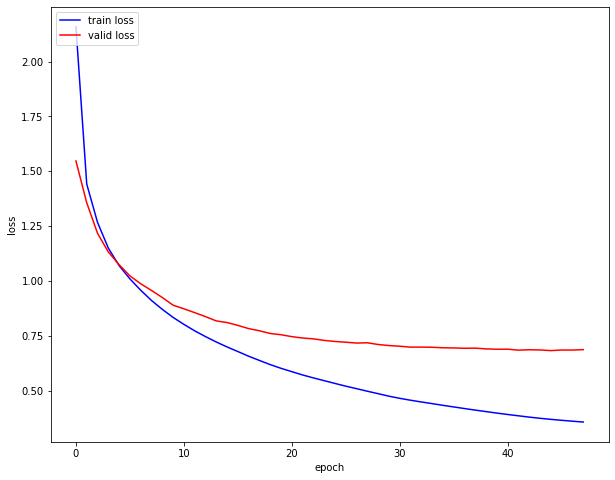

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(history.history['loss'], color='b',label = 'train loss')
ax.plot(history.history['val_loss'], color='r', label = 'valid loss')


ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax.legend(loc='upper left')

plt.show()

### test

In [25]:
# 인코더 재설계
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         577792    
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 131584    
Total params: 709,376
Trainable params: 709,376
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 디코더 재설계
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(embedding_dim,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(embedding_dim,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states2 = [state_h2, state_c2]

# 디코더 출력층 재설계
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1059072     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________________________

In [27]:
# 사전 준비
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [31]:
# 예측 과정을 위한 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx['<sos>']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += " " + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if sampled_char == '<eos>' or len(decoded_sentence) > max_fra_seq_len * 2:
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [32]:
def seq2eng(input_seq):
    sent = ""
    for i in input_seq:
        if i != 0:
            sent += idx2eng[i] + " "
    return sent

def seq2fra(input_seq):
    sent = ""
    for i in input_seq:
        if i != 0 and i != fra2idx["<sos>"] and i != fra2idx["<eos>"]:
            sent += idx2fra[i] + " "
    return sent

In [42]:
# 테스트
for seq_index in [5, 150, 500, 700, 1500]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2eng(encoder_input_test[seq_index]))
    print('정답 문장:', seq2fra(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:-5])

-----------------------------------
입력 문장: you ve got to go . 
정답 문장: tu dois t en aller . 
번역기가 번역한 문장:  il faut que tu y ailles . 
-----------------------------------
입력 문장: it is a book . 
정답 문장: c est un livre . 
번역기가 번역한 문장:  c est un livre . 
-----------------------------------
입력 문장: do you smoke ? 
정답 문장: est ce que vous fumez ? 
번역기가 번역한 문장:  est ce que tu vas que tu vas . 
-----------------------------------
입력 문장: open your hand . 
정답 문장: ouvre la main ! 
번역기가 번역한 문장:  ouvrez la main ! 
-----------------------------------
입력 문장: i have done that . 
정답 문장: j ai fait ça . 
번역기가 번역한 문장:  j ai fait cela . 


#### 번역 결과
- 구글 번역기로 번역한 결과 <br>

\[입력 문장\]
1. 당신은 가야합니다.
2. 그것은 책이다.
3. 담배를 피우십니까 ?
4. 손을 펴라!
5. 나는 이걸했다 .
<br>

\[출력 문장\]
1. 넌 가야 해.
2. 그것은 책이다.
3. 가니 가니?
4. 손을 펴라!
5. 나는 이걸했다.

## 회고

- 다른 프로젝트에서 썼던 전처리 함수를 그대로 사용할 경우 프랑스어의 악센트가 들어간 알파벳들이 사라진다. 따라서 유니코드를 추가하여 단어를 그대로 보존할 수 있도록 해주었다.
- 처음에 파라미터를 바꿔봐도 `val_loss`가 2점대 이하로 안떨어지고, 결과도 이상해서 뭐지 싶었는데, `max_eng_seq_len`과 `max_fra_seq_len`을 반대로 구했다... 삽질...
- 번역 결과 번역이 엉뚱하게 된 문장도 있지만 제대로 된 문장도 꽤 있었다. 특히 동사 형태(복수, 단수와 같은)만 다르거나 동의어를 써서 번역이 된 것도 있었다.
- embedding을 pre-trained 모델을 사용한다면 더 성능이 향상될 것 같다고 생각한다.